In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import gpitch
import pickle
import copy
import matplotlib.pyplot as plt
from gpitch.covsamp import optimize_kern
from gpitch.covsamp import approximate_kernel as appkern
from gpitch.methods import lfiles_training as fname

In [3]:
# number of components in kernel
D = 15

In [4]:
# set plot size
plt.rcParams['figure.figsize'] = (16, 4) 

# location data and matrices
path = 'data/training_data/'
save_path = 'params/'

ninst = 3  # number of intruments
npitch = 3  # number of pitches

# init lists to store data, cov matrixs and samples
init_list = [npitch*[None], npitch*[None], npitch*[None], npitch*[None]]
x = copy.deepcopy(init_list)  
y = copy.deepcopy(init_list)
cov = copy.deepcopy(init_list)
kern = copy.deepcopy(init_list)
xkern = copy.deepcopy(init_list)

if0 = copy.deepcopy(init_list)
freq = copy.deepcopy(init_list)
var = copy.deepcopy(init_list)

p0 = copy.deepcopy(init_list)
pstar = copy.deepcopy(init_list)

kern_init = copy.deepcopy(init_list)
kern_approx = copy.deepcopy(init_list)

S_kern_data = copy.deepcopy(init_list)
S_kern_init = copy.deepcopy(init_list)
S_kern_appr = copy.deepcopy(init_list)
hyperparams = copy.deepcopy(init_list)
rsize = 1600

for i in range(ninst):
    for p in range(npitch):
        print("Learning parametric kernel for " +  fname[i][p].strip('_train.wav'))
        
        # load audio
        x[i][p], y[i][p], fs = gpitch.readaudio(path + fname[i][p])
        
        # get autocorrelation
        kern[i][p] = gpitch.samplecov.autocorr(x=y[i][p], size=rsize)[0]
        
        # get time vector
        xkern[i][p] = x[i][p][0:kern[i][p].size].copy().reshape(-1, 1) # time vector for kernel

        # initialize variance and frequency from data FFT
        if0[i][p] = gpitch.find_ideal_f0([fname[i][p]])[0]
        freq[i][p], var[i][p] = gpitch.init_cparam(y=y[i][p], fs=fs, maxh=D, ideal_f0=if0[i][p], 
                                                   scaled=False)[0:2]
        
        # optimization
        p0[i][p] = np.hstack((np.array([0., 0.1]),  var[i][p], freq[i][p]))  # initialize params
        pstar[i][p] = optimize_kern(x=xkern[i][p], y=kern[i][p], p0=p0[i][p]) 
        print pstar[i][p]

        # get kernel hyperparameters
        npartials = (pstar[i][p].size - 2)/2
        noise_variance = pstar[i][p][0].copy()
        lengthscale =  pstar[i][p][1].copy()
        variance = pstar[i][p][2: npartials + 2].copy()/ np.sum(pstar[i][p][2: npartials + 2])
        frequency = pstar[i][p][npartials + 2:].copy()
        hyperparams[i][p] = [noise_variance, lengthscale, variance, frequency, xkern[i][p], kern[i][p]]
        
        # compute inital and learned kernel
        kern_init[i][p] = appkern(p0[i][p], xkern[i][p])
        kern_approx[i][p] = appkern(pstar[i][p], xkern[i][p])

        # spectral density data, init and learned kernel
        S_kern_data[i][p] = np.abs(sp.fftpack.fft(kern[i][p].reshape(-1,)))[0:rsize//2]
        S_kern_init[i][p] = np.abs(sp.fftpack.fft(kern_init[i][p].reshape(-1,)))[0:rsize//2]
        S_kern_appr[i][p] = np.abs(sp.fftpack.fft(kern_approx[i][p].reshape(-1,)))[0:rsize//2]
        
        # save hyperparameters
        pickle.dump(hyperparams[i][p], open(save_path + fname[i][p].strip('train.wav') + "hyperparams.p", "wb")) 

Learning parametric kernel for 011PFNOM_M60
[  0.00000000e+00   4.83214035e-01   8.86146221e-01   3.53305252e-02
   5.01734203e-03   1.69363012e-02   3.24589153e-02   2.39807307e-03
   4.37694686e-03   3.28782869e-03   3.58682071e-04   4.09159386e-04
   1.09438601e-03   1.48255929e-03   7.82295127e-05   1.43956163e-04
   3.72552701e-04   2.46300477e+02   4.94054593e+02   7.41124372e+02
   9.88913684e+02   1.23787330e+03   1.48777156e+03   1.73964186e+03
   1.99318354e+03   2.24714232e+03   2.50416253e+03   2.76321589e+03
   3.02387953e+03   3.28820603e+03   3.55822122e+03   4.10076434e+03]
Learning parametric kernel for 011PFNOM_M64
[  0.00000000e+00   4.83139715e-01   1.42237671e-05   4.68590840e-01
   4.39617009e-01   4.97189090e-02   4.19521357e-03   5.99961522e-03
   6.45667581e-03   2.17650308e-04   4.85070789e-03   6.31097051e-05
   4.83298032e-03   4.67299058e-04   1.95425348e-04   4.53082571e-05
   5.00307076e-05   3.15021153e+01   3.10875371e+02   6.22121819e+02
   9.34080500e

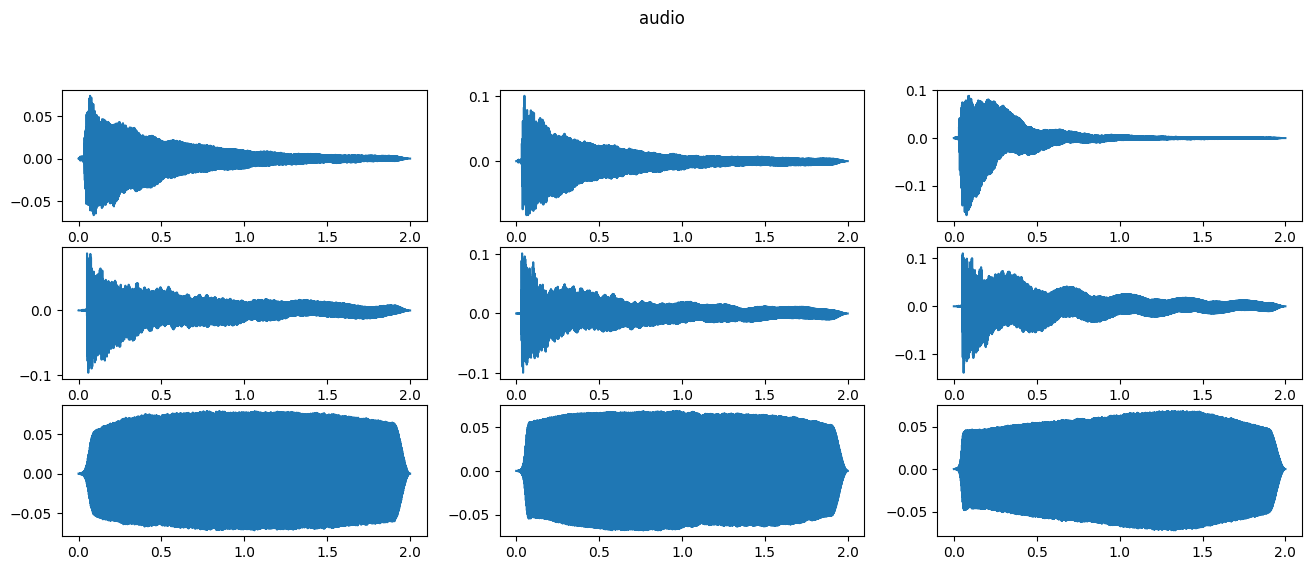

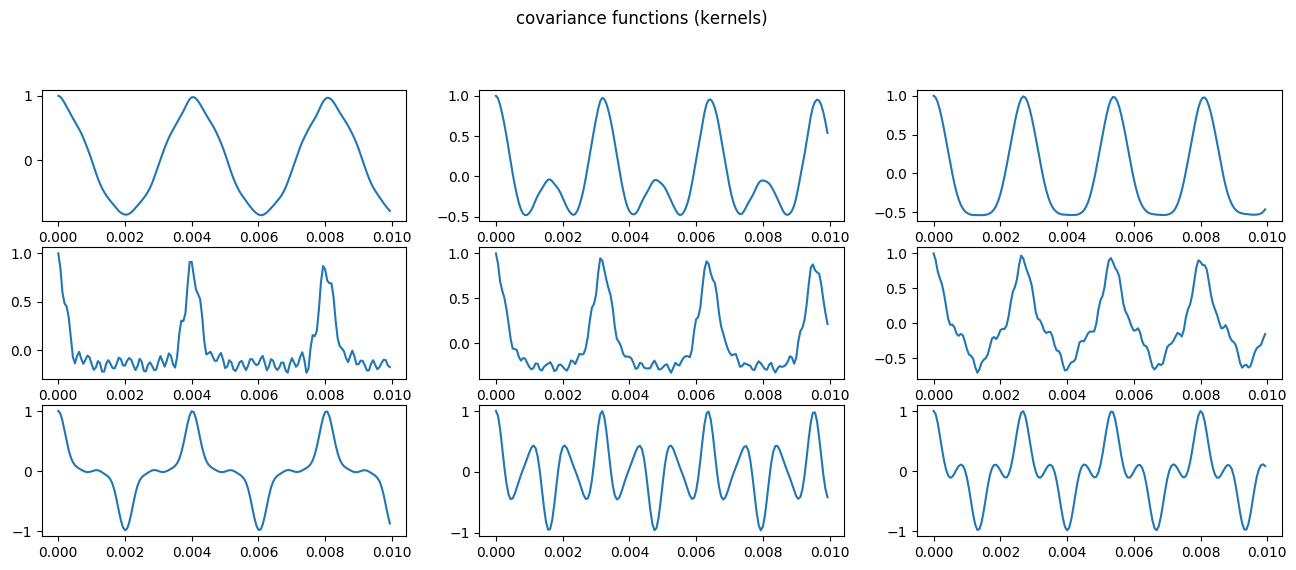

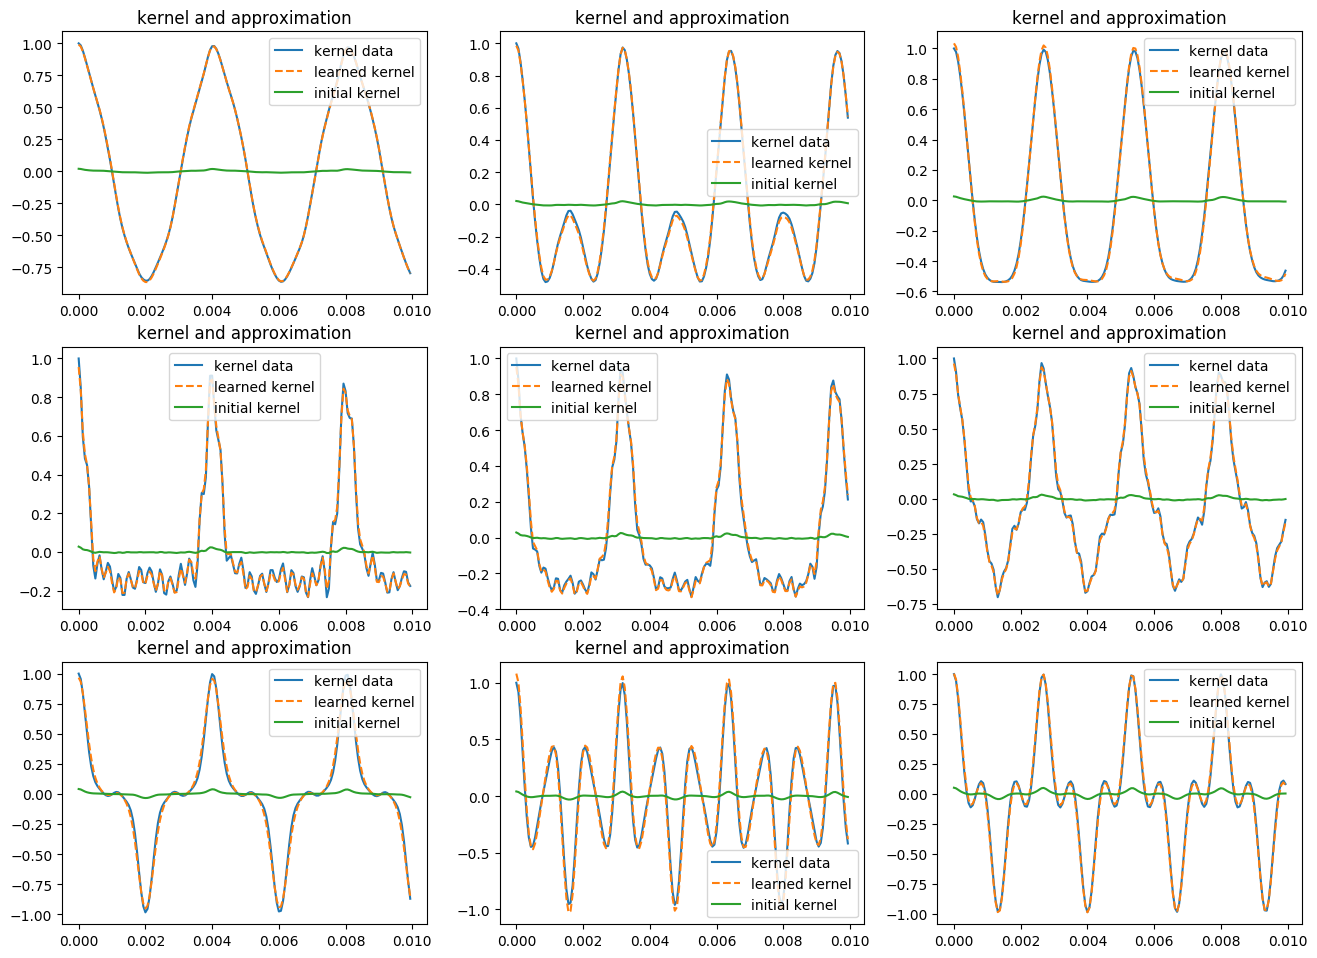

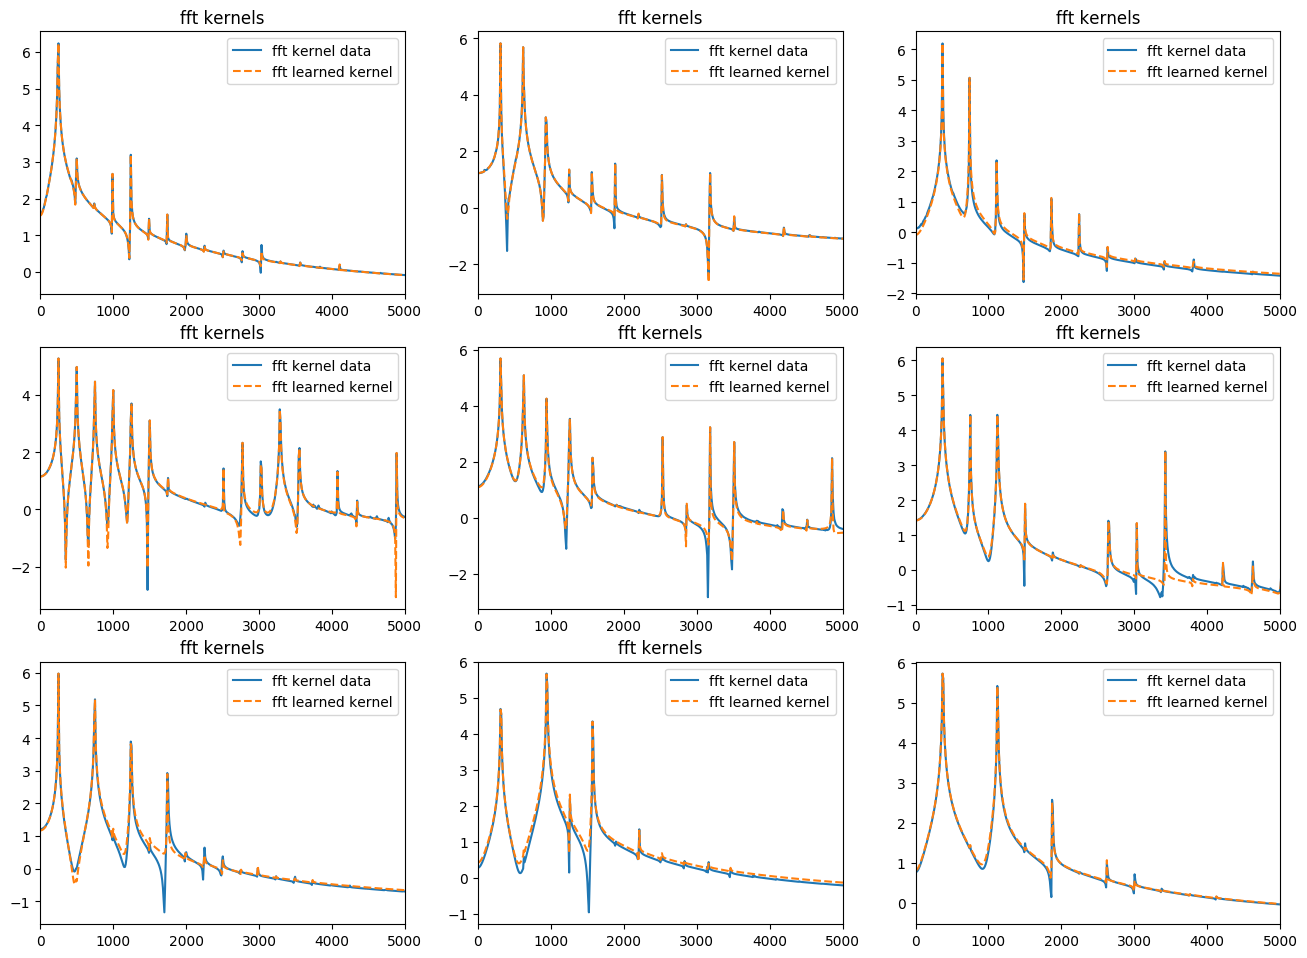

In [5]:
plt.rcParams.update({'font.size': 10})

F = np.linspace(0., fs/2., rsize//2).reshape(-1, 1)

nview = 1*160
for i in range(ninst):
    for p in range(npitch):
        # visualization
        plt.figure(1, figsize=(16, 8)), plt.suptitle('audio')
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(x[i][p], y[i][p])
                
        plt.figure(2, figsize=(16, 8)), plt.suptitle('covariance functions (kernels)')
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(xkern[i][p][0:nview], kern[i][p][0:nview]);
        
        
        plt.figure(4, figsize=(16, 16)), plt.title("kernel and approximation")
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(xkern[i][p][0:nview], kern[i][p][0:nview] )
        plt.plot(xkern[i][p][0:nview], kern_approx[i][p][0:nview], '--')
        plt.plot(xkern[i][p][0:nview], kern_init[i][p][0:nview])
        plt.legend(['kernel data','learned kernel', 'initial kernel'])
        
        plt.figure(5, figsize=(16, 16)), plt.title("fft kernels")
        plt.subplot(4, 3, (i*npitch + 1) + p)
        plt.plot(F, np.log(S_kern_data[i][p]))
        plt.plot(F, np.log(S_kern_appr[i][p]), '--')
        plt.legend(['fft kernel data', 'fft learned kernel'])
        plt.xlim(0, 5000)
        #plt.plot(np.log(S_kern_init[i][p]))
        #plt.legend(['fft kernel data', 'fft learned kernel', 'fft initial kernel'])

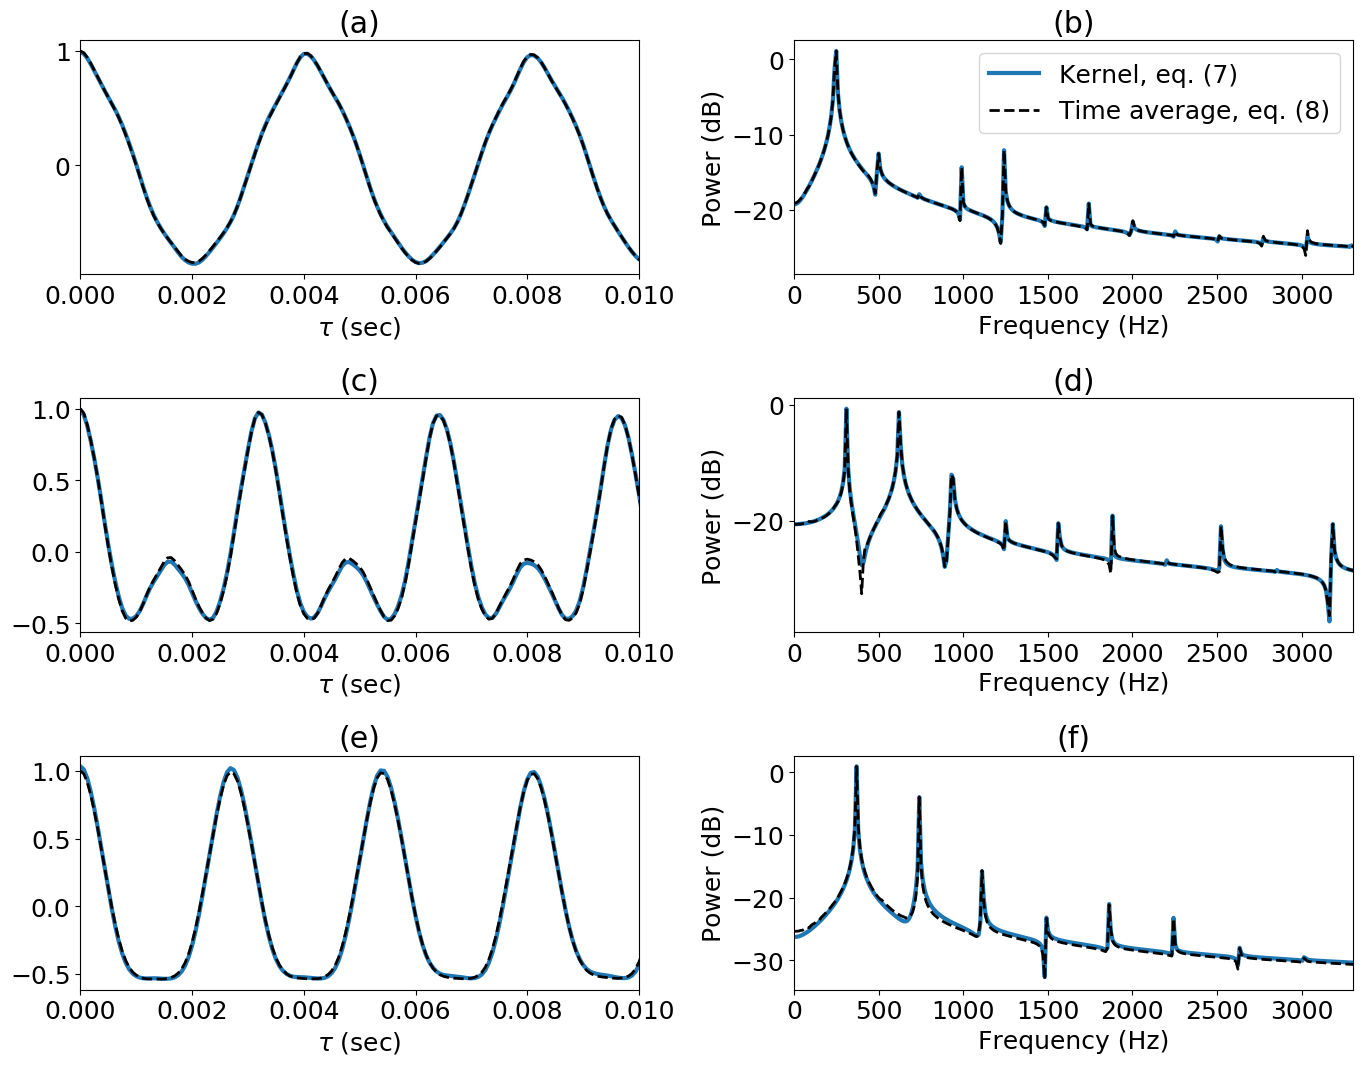

In [6]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(14, 11))

title = ["(a)", "(c)", "(e)", "(b)", "(d)", "(f)"]
for i in range(3):
    ax1 = plt.subplot(3, 2, 2*i+1)
    plt.plot(xkern[2][0], kern_approx[0][i], "C0", lw=3);
    plt.plot(xkern[2][0], 0.0 + kern[0][i], "k--", lw=2);
    plt.xlim(0., 0.01)
    #plt.ylim(-1., 1.1)
    plt.xlabel(r'$\tau$ (sec)')
    plt.title(title[i])
    #plt.legend(["Approximation", "Ground truth"], ncol=2, frameon=1)
    
    plt.subplot(3, 2, 2*i+2)
    plt.plot(F, 10*np.log10(S_kern_appr[0][i]/np.max(S_kern_appr[2][0])), "C0", lw=3)
    plt.plot(F, 10*np.log10(S_kern_data[0][i]/np.max(S_kern_data[2][0])), "k--", lw=2)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.title(title[i + 3])
    if i ==0:
        plt.legend([r"Kernel, eq. (7)", r"Time average, eq. (8)"], ncol=1, frameon=1, fontsize=18)
    plt.xlim(0, 3300)
    #plt.ylim(-40, 5)

plt.tight_layout()

plt.savefig("figures/3_kernels.pdf")